In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import scipy.signal as signal
import pandas as pd
from os.path import join
from kam11 import context, matchedFilter, thermister, rayModeling
from beamforming import curvedWaveFront, timeDomain, beam_correlations
from kam11.plotting import mfPlotting
from kam11.plotting import beamformer as beam_plotting
from kam11.helper import baseband

In [22]:
timeOfInterest='2011 J184 03:51:15'
loadDuration=dt.timedelta(0,5)
tof = dt.datetime.strptime(timeOfInterest, '%Y J%j %H:%M:%S')
ssp=thermister.getSoundSpeed(tof)

probeBounds = (-4.5, -4.1955)  # time bounds on lowest receiver
synth_angle = 6.25  # degrees
thetaRange=(0,8)
numTheta=300
beamformingRange=(-3,2)
numBeams=301
snap_index = 10
uprate = 5
look_theta = np.r_[thetaRange[0]:thetaRange[1]:numTheta*1j]
look_tau = np.r_[beamformingRange[0]:beamformingRange[1]:numBeams*1j]

In [23]:
mf = matchedFilter.mf_bytime(tof, loadDuration, baseband=False)
test_delay=curvedWaveFront.getDelays(look_theta, ssp, mf.rd, mf.rd[1])

ts, mf_time = mf.single_index(snap_index)

In [24]:
#create simulated data
timeI = (ts.index > min(probeBounds)) & (ts.index < max(probeBounds))
testSignal=ts.ix[timeI, ts.columns[0]]

synth_delay = curvedWaveFront.getDelays(synth_angle, ssp, mf.rd, mf.rd[1])

#create synthetic data set
synth_ts = np.zeros(ts.shape).T
for i, j in enumerate(np.squeeze(np.array(synth_delay))):
    timeI = ts.index >= j
    timeI = np.argmax(timeI)
    synth_ts[i, timeI:timeI+testSignal.size] = testSignal

#bandpass signal to bw of data
nfilter = 256
b = signal.remez(nfilter, [0, 9000, 11500, 34500, 37000, 50000],
                 [0,1,0], Hz = 1e5)
b = np.array(b, ndmin = 2)
synth_ts = signal.convolve(synth_ts, b, 'same')

#extend synthetic data to twice the length
synth_ts = np.concatenate((np.zeros(synth_ts.shape), synth_ts), axis=1)
dt = ts.index[1] - ts.index[0]
synth_time = np.concatenate((ts.index - max(ts.index) + min(ts.index) - dt,
                             ts.index))

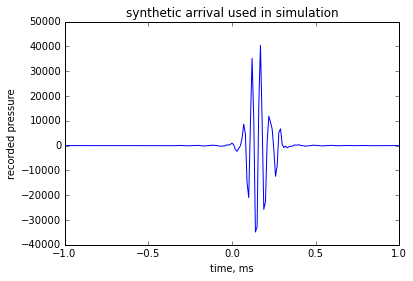

In [30]:
_=plt.plot(synth_time, synth_ts[0,:])
_=plt.xlim(-1, 1)
_=plt.xlabel('time, ms')
_=plt.ylabel('recorded pressure')
_=plt.title('synthetic arrival used in simulation')
_=plt.savefig('/Users/edwardlrichards/ipythonNotebooks/nogit/beamforming_083115/simWF')

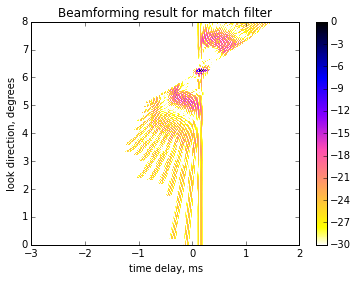

In [31]:
beamformer = timeDomain.ShiftAndAdd(synth_ts.T, tAxis=synth_time, upsample=5)
bf = beamformer.beamform(look_tau, test_delay)
ax=beam_plotting.plot_beamformer(look_theta, look_tau, bf, vmin=-30)
plt.savefig('/Users/edwardlrichards/ipythonNotebooks/nogit/beamforming_083115/beam_synth')

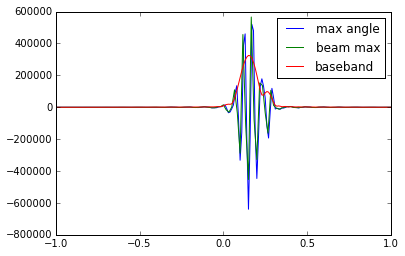

In [6]:
ts_max = beamformer.beamform(np.array(ts.index), synth_delay)
maxAngle = beam_correlations.maxangle(bf, (-2, 2), (4,8))
beamMax = bf[bf.columns.asof(maxAngle)]
bb_max = baseband.baseband(ts_max)
_=plt.plot(ts_max.index, np.real(ts_max), label='max angle')
_=plt.xlim(-1, 1)
_=plt.plot(beamMax.index, np.real(beamMax), label = 'beam max')
_=plt.plot(bb_max.index, np.abs(bb_max), label = 'baseband')
_=plt.legend()

In [15]:
%autoreload
synth_bb, time_bb = baseband.baseband(synth_ts.T, tAxis = synth_time)
bb_beamformer = timeDomain.ShiftAndAdd(synth_bb, tAxis=time_bb, upsample=5)
bb_bf = bb_beamformer.beamform(look_tau, test_delay)

In [16]:
bb_max = np.abs(bb_bf).max().idxmax()
print('max angle of baseband beamforming is %.2f'%bb_max)
test_delay = curvedWaveFront.getDelays(bb_max, ssp, mf.rd, mf.rd[1])
max_tau = np.squeeze(np.array(test_delay))

max angle of baseband beamforming is 6.05


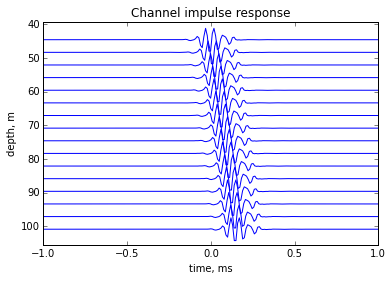

In [17]:
plot_synth = pd.DataFrame(synth_ts.T, index = synth_time, columns=mf.rd)
ax = mfPlotting.plotSingleTime(plot_synth, isDB = False,
                          channel_delays=max_tau,
                          vmin=-3e4, vmax = 3e4,
                          tStart=-1, tEnd = 1)

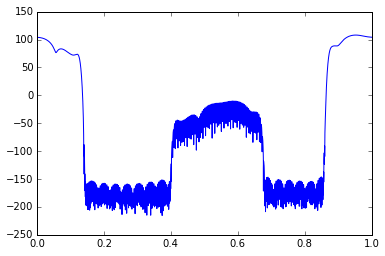

In [18]:
bb_FT = np.fft.fft(synth_bb[:,0])
faxis = np.arange(bb_FT.size) / bb_FT.size
_ = plt.plot(faxis, 20 * np.log10(np.abs(bb_FT)))
# _ = plt.plot(faxis, np.imag(bb_FT))

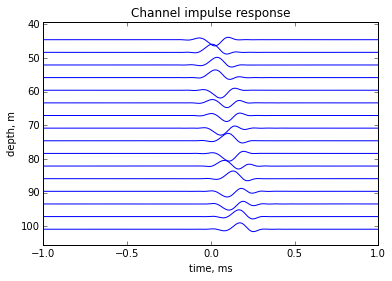

In [12]:
plot_bb = pd.DataFrame(np.real(synth_bb),
                       index = time_bb, columns=mf.rd)
ax = mfPlotting.plotSingleTime(plot_bb, isDB = False,
                          channel_delays=max_tau,
                          vmin=-3e4, vmax = 3e4,
                          tStart=-1, tEnd = 1)

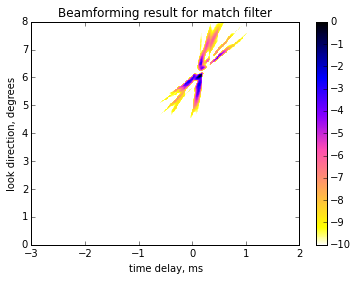

In [13]:
ax=beam_plotting.plot_beamformer(look_theta, look_tau, bb_bf, vmin=-10)

In [ ]:
plot_bb = pd.DataFrame(np.real(synth_bb),
                       index = time_bb, columns=mf.rd)

ax = mfPlotting.plotSingleTime(plot_bb, isDB = False,
                          channel_delays=max_tau,
                          vmin=-3e4, vmax = 3e4,
                          tStart=-1, tEnd = 1)